In [298]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [299]:
random.seed(42)

## Set parameters

In [300]:
STD_PRICE = 0.2 / math.sqrt(12)
STD_EARNINGS = 0.04 / math.sqrt(12)
CORRELATION = 0.5
BIAS = 1.05 ** (1/12) - 1

## Calculate required statistics

In [301]:
variance_price = STD_PRICE ** 2
variance_earnings = STD_EARNINGS ** 2
covariance = CORRELATION * math.sqrt((variance_price) * (variance_earnings))
covariance_matrix = [[variance_price, covariance], [covariance, variance_earnings]]

In [322]:
def random_cape(sample_size):
    '''Generate a random time series with covariance matrix as defined in parameters above'''
    sample = np.random.multivariate_normal([BIAS, BIAS], covariance_matrix, sample_size*12)
    df = pd.DataFrame(sample, columns = ['Price', 'Earnings'])
    df = (df + 1).cumprod()
    cape = df.Price / df.Earnings.rolling(121).mean()
    forward_rets = ((df.Price / df.Price.shift(120)) - 1)
    slope = np.polyfit(cape.dropna(),forward_rets.dropna(),1)[0]
    return {'Data' : df,
            'Ratios' : {'cape' : cape,
                        'rets' : forward_rets},
            'Slope': slope}

## Run a series of 100 tests for different time horizons and store all data as well as average regression coefficients for simulated cape ratio

In [315]:
nested_results = {}
time_horizons = [20, 50, 100, 200, 500]
for j in time_horizons:
    results = {}
    for i in range(0,100):
        results[i] = random_cape(j)
    nested_results[j] = results

average_slopes = {time : np.mean([slope['Slope'] for slope in nested_results[time].values()]) for time in time_horizons}

In [320]:
average_slopes
# Average slopes are clearly decreasing with longer simulated time horizons

{20: 1.767725719859328,
 50: 1.6131970123878432,
 100: 1.1821173712861606,
 200: 0.4444607065533009,
 500: 0.2509918311403704}

## Easily observed in charts:

<Axes: >

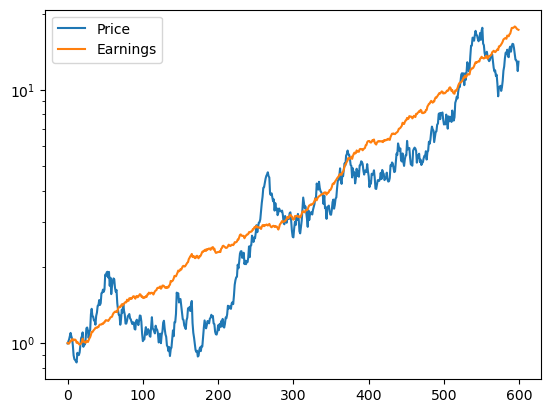

In [324]:
nested_results[50][0]['Data'].plot(logy=True)

<Axes: ylabel='Price'>

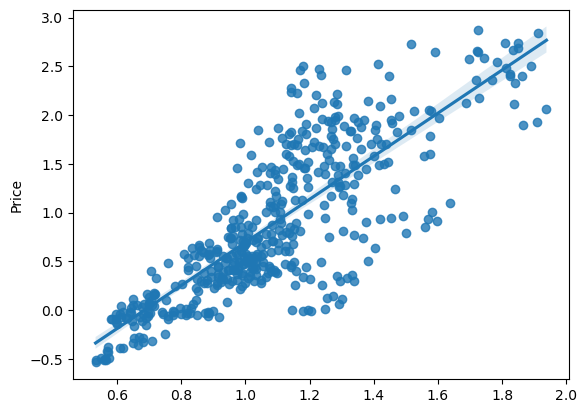

In [319]:
sns.regplot(x=nested_results[50][0]['Ratios']['cape'], y=nested_results[50][0]['Ratios']['rets'])

<Axes: >

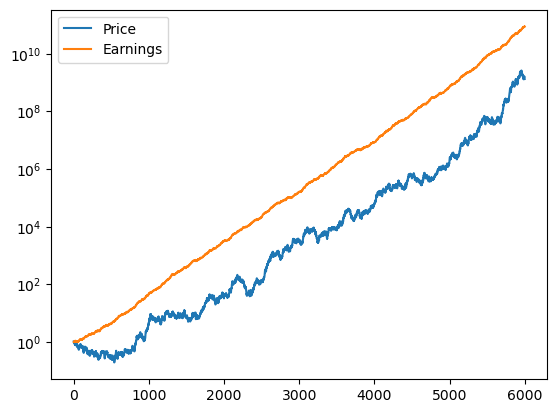

In [325]:
nested_results[500][0]['Data'].plot(logy=True)

<Axes: ylabel='Price'>

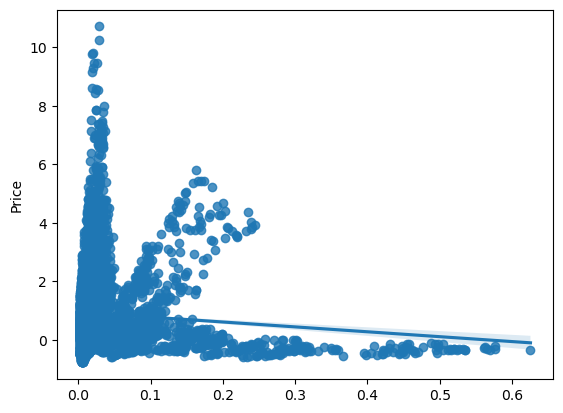

In [321]:
sns.regplot(x=nested_results[500][0]['Ratios']['cape'], y=nested_results[500][0]['Ratios']['rets'])